# Data loading

In [7]:
FOLDER = "dataset"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import json
import string
from collections import Counter

import nltk
from nltk.corpus import wordnet

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, TimeDistributed, Dropout, LayerNormalization, Flatten, RepeatVector
from tensorflow.keras.layers import GRU
from tensorflow.keras import layers, models  # Add this import if it's not already there
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotUniform, Zeros
from tensorflow.keras import regularizers

from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# import torch.nn.utils.rnn as rnn_utils

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.debugging.set_log_device_placement(True)

In [8]:
# Load the train.csv file
train_df = pd.read_csv(f'{FOLDER}/shuffled_A_B_relation_train.csv')
train_df

,EventA,EventB,relation
0,PersonX causes trouble,"['Is arrested', 'Thrown in jail']",xEffect
1,PersonX drops off the radar,"['has peace an quiet', 'gets more sleep']",xEffect
2,PersonX starts the fire,"['to light a match', 'to pour gasoline everywh...",xNeed
3,PersonX attends to PersonY's duties,"['to hear thanks', 'keep helping person']",xWant
4,PersonX lets PersonY go,"['sad, but helpful']",xReact
...,...,...,...
319770,PersonX closes PersonY's doors,"['helpful', 'generous']",xReact
319771,PersonX has a pizza party,"['thank personx', 'help clean up']",oWant
319772,PersonX invites PersonY to PersonX's house,['like he made a friend'],xReact
319773,PersonX blows PersonY's nose,"['to protest', 'to thank PersonX']",oWant


In [9]:
size = 20000
train_df_subset = train_df.sample(n=size, random_state=42)
# train_df_subset = train_df # take all data instead

# Split the subset into training and validation sets (4:1 ratio)
train_data, val_data = train_test_split(train_df_subset, test_size=0.2, random_state=42)

print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")

Training data size: 16000
Validation data size: 4000


In [10]:
train_data

,EventA,EventB,relation
25211,PersonX spends more time,['good'],xReact
170959,PersonX calls PersonX's bank,"['wait employee.', 'gets information.']",xEffect
169471,PersonX answers the ___ well,"['To go out', 'To get free']",xWant
65497,PersonX walks along the street,"['enters a building', 'gets in a car']",xEffect
171258,PersonX gets PersonY a puppy,"['sweet', 'kind']",xAttr
...,...,...,...
280662,PersonX wants blonde hair,"['to have different colored hair', 'to be unha...",xNeed
176643,PersonX wraps PersonY's arms around PersonY,['happy that he is helping them to be friends'],xReact
20355,PersonX draws PersonY close,['affectionate'],xReact
208263,PersonX gives PersonY look,"['He is thinking of what he did wrong', 'Asks ...",oEffect


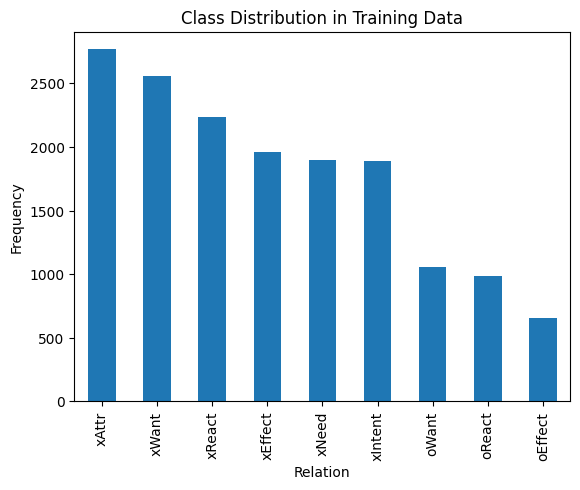

In [11]:
relation_counts = train_data['relation'].value_counts()
relation_counts.plot(kind='bar')
plt.xlabel('Relation')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Data')
plt.show()

In [12]:
train_data["relation"].unique()

array(['xReact', 'xEffect', 'xWant', 'xAttr', 'oWant', 'oEffect', 'xNeed',
       'xIntent', 'oReact'], dtype=object)

Define Custom Dataset Class

In [ ]:
# # Step 1: Construct the relation vocabulary
# relations = train_data['relation'].unique()
# relation_vocab = {relation: idx for idx, relation in enumerate(relations)}
# print("Relation Vocabulary:", relation_vocab)

# Data Augmentation
为了适应生成任务，需要对数据集的准备方式进行调整，使其适用于序列到序列（Seq2Seq）模型。
为了提高模型效果，建议进行更高级的文本预处理，例如统一大小写和去除标点符号。

In [13]:
# Augmented data file path
augmented_file_path = f'{FOLDER}/augmented_data.csv'

nltk.download('wordnet')
nltk.download('omw-1.4')

# Check if the augmented dataset already exists
if os.path.exists(augmented_file_path):
    # Load the augmented dataset if it already exists
    augmented_df = pd.read_csv(augmented_file_path)
    print("Loaded existing augmented dataset.")
else:
    # Perform data augmentation if the file doesn't exist

    def synonym_replacement(sentence, n=2):
        words = sentence.split()
        new_words = words.copy()

        # Randomly shuffle the words that have synonyms in WordNet
        random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
        random.shuffle(random_word_list)

        num_replaced = 0
        for random_word in random_word_list:
            synonyms = wordnet.synsets(random_word)
            if synonyms:
                # Pick the first synonym and replace underscores if any
                synonym = synonyms[0].lemmas()[0].name().replace('_', ' ')
                if synonym != random_word:
                    # Replace the original word with the synonym
                    new_words = [synonym if word == random_word else word for word in new_words]
                    num_replaced += 1
                if num_replaced >= n:
                    break
        return ' '.join(new_words)

    augmented_data = []

    for _, row in train_data.iterrows():
        event_a = row['EventA']  # Original event A (e.g., "PersonX gives a compliment")
        event_b = row['EventB']  # Original event B (e.g., "PersonY smiles")
        relation = row['relation']  # Relationship between event A and B (e.g., "xIntent")

        # Original data
        augmented_data.append({'EventA': event_a, 'EventB': event_b, 'relation': relation})

        # Augmented data for eventA and eventB
        augmented_event_a = synonym_replacement(event_a)
        augmented_event_b = synonym_replacement(event_b)

        # Add augmented data
        augmented_data.append({'EventA': augmented_event_a, 'EventB': event_b, 'relation': relation})
        augmented_data.append({'EventA': event_a, 'EventB': augmented_event_b, 'relation': relation})
        augmented_data.append({'EventA': augmented_event_a, 'EventB': augmented_event_b, 'relation': relation})

    # Convert to DataFrame
    augmented_df = pd.DataFrame(augmented_data)

    # Save the augmented DataFrame to a CSV file
    augmented_df.to_csv(augmented_file_path, index=False)

    print("Augmented dataset saved to:", augmented_file_path)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\terry\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\terry\AppData\Roaming\nltk_data...


Augmented dataset saved to: dataset/augmented_data.csv


In [14]:
nltk.download('punkt_tab')

def preprocess_text(text):
    # 小写化
    text = text.lower()
    # 去除标点符号
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 分词
    tokens = nltk.word_tokenize(text)
    return tokens

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\terry\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


In [15]:
VOCAB_PATH = os.path.join(FOLDER, 'vocab.json')

# 检查是否存在 vocab.json
if os.path.exists(VOCAB_PATH):
    # 加载现有的词汇表
    with open(VOCAB_PATH, 'r') as f:
        vocab = json.load(f)
    print("Loaded existing vocabulary.")

else:

    # 获取所有文本
    all_text = augmented_df['EventA'].tolist() + augmented_df['EventB'].tolist()

    all_tokens = []
    for text in all_text:
        # tokens = text.split()
        tokens = preprocess_text(text)
        all_tokens.extend(tokens)

    # 统计词频
    token_counter = Counter(all_tokens)

    # 创建词汇表，保留高频词，其他的映射为 <unk>
    # 例如，仅保留出现超过2次的词
    # might be too much, remove the freq thereshold
    vocab = {word: idx + 4 for idx, (word, count) in enumerate(token_counter.items())}
    vocab['<pad>'] = 0
    vocab['<unk>'] = 1    # unknown
    vocab['<start>'] = 2 # 序列开始标记
    vocab['<end>'] = 3    # 序列结束标记
    print(f"Vocabulary size: {len(vocab)}")

    # 保存词汇表
    with open(f'{FOLDER}/vocab.json', 'w') as f:
        json.dump(vocab, f)

Vocabulary size: 9073


In [16]:
vocab_size = max(vocab.values()) + 1
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 9073


In [17]:
max_index = max(vocab.values())
print(f"Maximum index in vocab: {max_index}")
print(f"Vocabulary size: {vocab_size}")
assert max_index < vocab_size, "Error: Max index exceeds vocab_size"

Maximum index in vocab: 9072
Vocabulary size: 9073


In [18]:
# Construct the relation vocabulary
relations = train_data['relation'].unique()
relation_vocab = {relation: idx for idx, relation in enumerate(relations)}
inverse_relation_vocab = {idx: relation for relation, idx in relation_vocab.items()}
print("Relation Vocabulary:", relation_vocab)
print("Inverse Relation Vocabulary:", inverse_relation_vocab)

Relation Vocabulary: {'xReact': 0, 'xEffect': 1, 'xWant': 2, 'xAttr': 3, 'oWant': 4, 'oEffect': 5, 'xNeed': 6, 'xIntent': 7, 'oReact': 8}
Inverse Relation Vocabulary: {0: 'xReact', 1: 'xEffect', 2: 'xWant', 3: 'xAttr', 4: 'oWant', 5: 'oEffect', 6: 'xNeed', 7: 'xIntent', 8: 'oReact'}


预处理函数定义

将文本和关系标签转换为索引序列，并进行填充和截断

In [19]:
def preprocess_task2_input(dataframe, vocab, relation_vocab, max_length=15):
    input_a_list = []
    relation_list = []
    target_b_input_list = []
    target_b_output_list = []

    for _, row in dataframe.iterrows():
        event_a = row['EventA']
        relation = row['relation']
        event_b = row['EventB']

        # 预处理 EventA
        tokens_a = preprocess_text(event_a)
        input_a_indices = [vocab.get(word, vocab['<unk>']) for word in tokens_a]
        if len(input_a_indices) > max_length:
            input_a_indices = input_a_indices[:max_length]
        else:
            input_a_indices += [vocab['<pad>']] * (max_length - len(input_a_indices))
        input_a_list.append(input_a_indices)

        # 编码 Relation
        relation_idx = relation_vocab[relation]
        relation_list.append(relation_idx)

        # 预处理 EventB
        tokens_b = preprocess_text(event_b)
        target_b_indices = [vocab.get(word, vocab['<unk>']) for word in tokens_b]
        if len(target_b_indices) > max_length - 2:  # 留出 <start> 和 <end>
            target_b_indices = target_b_indices[:max_length - 2]
        else:
            target_b_indices += [vocab['<pad>']] * (max_length - 2 - len(target_b_indices))

        # 创建 decoder 输入和输出
        target_b_input = [vocab['<start>']] + target_b_indices
        target_b_output = target_b_indices + [vocab['<end>']]

        # 填充至 max_length
        if len(target_b_input) < max_length:
            target_b_input += [vocab['<pad>']] * (max_length - len(target_b_input))
        if len(target_b_output) < max_length:
            target_b_output += [vocab['<pad>']] * (max_length - len(target_b_output))

        target_b_input_list.append(target_b_input)
        target_b_output_list.append(target_b_output)

    # 转换为 numpy 数组
    input_a_np = np.array(input_a_list, dtype=np.int32)
    relation_np = np.array(relation_list, dtype=np.int32)
    target_b_input_np = np.array(target_b_input_list, dtype=np.int32)
    target_b_output_np = np.array(target_b_output_list, dtype=np.int32)

    # 将目标输出扩展为 (batch_size, max_length, 1) 以适应 sparse_categorical_crossentropy
    target_b_output_np = np.expand_dims(target_b_output_np, axis=-1)

    return input_a_np, relation_np, target_b_input_np, target_b_output_np

## Data -> tf format

In [20]:
class AtomicDataset2(tf.data.Dataset):
    def __new__(cls, dataframe, vocab, relation_vocab, max_length=15):
        input_a, relation, target_b_input, target_b_output = preprocess_task2_input(dataframe, vocab, relation_vocab, max_length)
        return tf.data.Dataset.from_tensor_slices(((input_a, relation, target_b_input), target_b_output))

In [21]:
# Step 4: Create training and validation datasets
train_data_augmented, val_data_augmented = train_test_split(augmented_df, test_size=0.2, random_state=42)

train_dataset = AtomicDataset2(train_data_augmented, vocab, relation_vocab)
val_dataset = AtomicDataset2(val_data_augmented, vocab, relation_vocab)

# Set batch size
batch_size = 512

# Shuffle and batch the training dataset, plus prefetch caching the dataset
train_dataset = train_dataset.shuffle(buffer_size=len(train_data_augmented)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DummySeedGene

In [22]:
# testing dataset
for i, ((input_a, relation, target_b_input), target_b_output) in enumerate(train_dataset.take(1)):
    print(f"Input A shape: {input_a.shape}")  # (batch_size, max_length)
    print(f"Relation shape: {relation.shape}")  # (batch_size,)
    print(f"Target B Input shape: {target_b_input.shape}")  # (batch_size, max_length)
    print(f"Target B Output shape: {target_b_output.shape}")  # (batch_size, max_length, 1)
    print(f"Input A (Index {i}): {input_a.numpy()}")
    print(f"Relation (Index {i}): {relation.numpy()}")
    print(f"Target B Input (Index {i}): {target_b_input.numpy()}")
    print(f"Target B Output (Index {i}): {target_b_output.numpy()}")

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Input A shape: (512, 15)
Relation shape: (512,)
Target B Input shape: (512, 15)
Target B Output shape: (512, 15, 1)
Input A (Index 0): [[   4  830   26 ...    0    0    0]
 [   4  221   14 ...    0    0    0]
 [   4 2177   26 ...    0    0    0]
 ...
 [   4  239   22 ...    0    0    0]
 [   4 1318  240 ...    0    0    0]
 [   4 3769 2255 ...    0    0    0]]
Relation (Index 0): [0 2 7 6 6 1 5 1 0 4 0 3 4 1 0 2 3 2 2 1 6 2 4 0 0 8 3 6 3 0 1 1 3 7 0 2 7
 6 4 2 3 2 1 4 7 2 3 6 2 7 0 4 8 4 1 8 0 6 0 6 3 7 5 3 6 2 8 6 2 0 2 0 0 4
 1 7 0 2 0 6 3 0 1 6 6 7 3 2 2 3 0 7 1 6 1 6 0 4 8 3 1

# Training

使用编码器-解码器（Seq2Seq）架构定义生成模型：

In [23]:
# Step 5: Define LSTM Model
vocab_size = max(vocab.values()) + 1
embedding_dim = 32           # Dimension of word embeddings
hidden_dim = 128             # Hidden dimension of LSTM
relation_embedding_dim = 16  # Relation 嵌入维度
max_length = 15              # 序列最大长度

Task Differences:

•	Task 1 is a classification problem, where the model is provided with two events and has to classify the relationship between them.

•	Task 2 is a generation problem, where the model is given an event A and a logical relationship, and it has to generate a plausible event B.

Key Changes in the Model for Task 2:

1.	Input-Output Format:

•	Task 2 requires the model to predict an entire sequence (Event B), not just a single label.

•	This implies that instead of predicting a classification label, the model should predict a sequence of tokens, similar to text generation.
2.	Model Structure for Generation:

•	Instead of a classification head (Dense layer with softmax to predict class labels), Task 2 requires a sequence-to-sequence model structure.

•	We need an LSTM (or similar) that can handle both encoder and decoder parts.

Proposed Model Architecture for Task 2:

For Task 2, a Sequence-to-Sequence model (Seq2Seq) architecture is more suitable. Below is a suggested structure:
	1.	Encoder: Encodes Event A and relation.
	2.	Decoder: Generates Event B.


In [24]:
'''
# Encoder inputs
encoder_inputs = Input(shape=(max_length,), name='encoder_inputs')       # Event A
encoder_relation = Input(shape=(1,), name='encoder_relation')            # Relation

# Embedding layers
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(encoder_inputs)
relation_embedding = Embedding(input_dim=len(relation_vocab), output_dim=relation_embedding_dim)(encoder_relation)
relation_embedding_flat = Flatten()(relation_embedding)

# Repeat the relation embedding to match the sequence length
relation_embedding_repeated = RepeatVector(max_length)(relation_embedding_flat)

# Concatenate the event and relation embeddings
encoder_combined = Concatenate()([encoder_embedding, relation_embedding_repeated])

# Encoder LSTM
encoder_lstm = LSTM(hidden_dim, return_state=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_combined)

# Decoder inputs
decoder_inputs = Input(shape=(max_length,), name='decoder_inputs')  # Event B input
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

# Output layer
decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

'''


# Encoder inputs
encoder_inputs = Input(shape=(max_length,), name='encoder_inputs')
encoder_relation = Input(shape=(1,), name='encoder_relation')

# Embedding layers
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(encoder_inputs)
relation_embedding = Embedding(input_dim=len(relation_vocab), output_dim=relation_embedding_dim)(encoder_relation)
relation_embedding_flat = Flatten()(relation_embedding)
relation_embedding_repeated = RepeatVector(max_length)(relation_embedding_flat)

# Concatenate embeddings
encoder_combined = Concatenate()([encoder_embedding, relation_embedding_repeated])

# Encoder GRU
encoder_gru = GRU(hidden_dim, return_state=True, name='encoder_gru')
encoder_outputs, state_h = encoder_gru(encoder_combined)

# Decoder inputs
decoder_inputs = Input(shape=(max_length,), name='decoder_inputs')
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(decoder_inputs)

# Decoder GRU
decoder_gru = GRU(hidden_dim, return_sequences=True, return_state=True, name='decoder_gru')
decoder_outputs, _ = decoder_gru(decoder_embedding, initial_state=[state_h])

# Output layer
decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the Seq2Seq model
model_task2 = Model([encoder_inputs, encoder_relation, decoder_inputs], decoder_outputs)

# Compile the model
model_task2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model_task2.summary()

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Step 6: Train the Model
epochs = 5  # Number of epochs for training

# Train the model
history = model_task2.fit(
    train_dataset,
    validation_data=val_dataset,  # Use validation dataset during training
    epochs=epochs,
    callbacks=[early_stopping],
    verbose=1  # Display progress bar during training
)

Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GreaterEqual in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity i

In [28]:
# Step 7: Save the trained model
model_save_path = 'results/trained_lstm_model_task2.h5'  # You can specify any path you like
model_task2.save(model_save_path)

print(f"Model saved to {model_save_path}")

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

In [ ]:
from tensorflow.keras.models import load_model

# # Load the saved model
model = load_model('trained_lstm_model_task2.h5')

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

# Prediction

In [ ]:
# task 2 only
def generate_event_b(model, input_text, vocab, max_length=15):
    # Preprocess the input text to convert it into indices
    tokens = input_text.split()
    input_indices = [vocab.get(word, 0) for word in tokens]

    # Pad or truncate the input to the desired length
    if len(input_indices) > max_length:
        input_indices = input_indices[:max_length]
    else:
        input_indices += [0] * (max_length - len(input_indices))

    # Convert to NumPy array
    input_np = np.array([input_indices], dtype=np.int32)

    # Generate the output sequence
    predictions = model.predict(input_np)
    generated_indices = np.argmax(predictions, axis=-1)

    # Convert generated indices back to words
    reverse_vocab = {idx: word for word, idx in vocab.items()}
    generated_words = [reverse_vocab.get(idx, '<unk>') for idx in generated_indices[0]]

    return ' '.join(generated_words)

# Example usage
input_text = "PersonX pays PersonY a compliment xIntent"  # EventA + Relation
generated_event_b = generate_event_b(model, input_text, vocab)
print("Generated Event B:", generated_event_b)

NameError: name 'model' is not defined

In [ ]:
def preprocess_input(dataframe, vocab, max_length=15):
    features_list = []

    for _, row in dataframe.iterrows():
        # Concatenate EventA and EventB
        features = row['EventA'] + " " + row['EventB']
        tokens = features.split()

        # Convert tokens to indices
        feature_indices = [vocab.get(word, 0) for word in tokens]

        # Pad or truncate sequences
        if len(feature_indices) > max_length:
            feature_indices = feature_indices[:max_length]
        else:
            feature_indices += [0] * (max_length - len(feature_indices))

        features_list.append(feature_indices)

    # Convert to NumPy array
    features_np = np.array(features_list, dtype=np.int32)
    return features_np

In [ ]:
for i in range(5):
    # Step 1: Randomly select one data point from train_df[100000:] # size = 100000
    random_index = random.randint(0, len(train_df) - 1)
    random_sample = train_df.iloc[random_index:random_index + 1]

    # Step 2: Preprocess the selected input using the function you defined earlier
    input_features_np = preprocess_input(random_sample, vocab)

    # Step 3: Get the correct output label for comparison
    correct_relation = random_sample['relation'].values[0]

    # Step 4: Make the prediction
    predictions = model.predict(input_features_np)

    # Step 5: Convert prediction to class label
    predicted_class = np.argmax(predictions, axis=-1)[0]  # Since it's only one input
    inverse_relation_vocab = {v: k for k, v in relation_vocab.items()}
    predicted_label = inverse_relation_vocab[predicted_class]

    # Step 6: Display the input, correct output, and predicted output
    print("Input Features:", random_sample['EventA'].values[0], "+", random_sample['EventB'].values[0])
    print("Correct Output:", correct_relation)
    print("Predicted Output:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Input Features: PersonX teaches ___ for years + ['devoted', 'enthusiastic']
Correct Output: xAttr
Predicted Output: xAttr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Input Features: PersonX puts PersonY's arm around PersonY + ['has body contact with PersonY', 'gets attached to PersonY']
Correct Output: xEffect
Predicted Output: xEffect
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Input Features: PersonX reads PersonY article + ['glad that he could help person']
Correct Output: xReact
Predicted Output: xReact
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Input Features: PersonX petitions the ___ for a redress + ['to start a blog', 'to protest']
Correct Output: xNeed
Predicted Output: xNeed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Input Features: PersonX sees a car + ['go to ride', 'to buy a new car']
Correct Output: xEffect
Predicted Output: xWant


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Make predictions on the validation dataset
val_features = []
val_labels = []

for features, label in val_dataset:
    val_features.append(features.numpy())
    val_labels.append(label.numpy())

# Convert lists to numpy arrays
val_features_np = np.concatenate(val_features, axis=0)
val_labels_np = np.concatenate(val_labels, axis=0)

# Get predictions
predictions = model.predict(val_features_np)
predicted_labels = np.argmax(predictions, axis=-1)

# Step 2: Generate confusion matrix
cm = confusion_matrix(val_labels_np, predicted_labels)

6396/6396 ━━━━━━━━━━━━━━━━━━━━ 110s 17ms/step


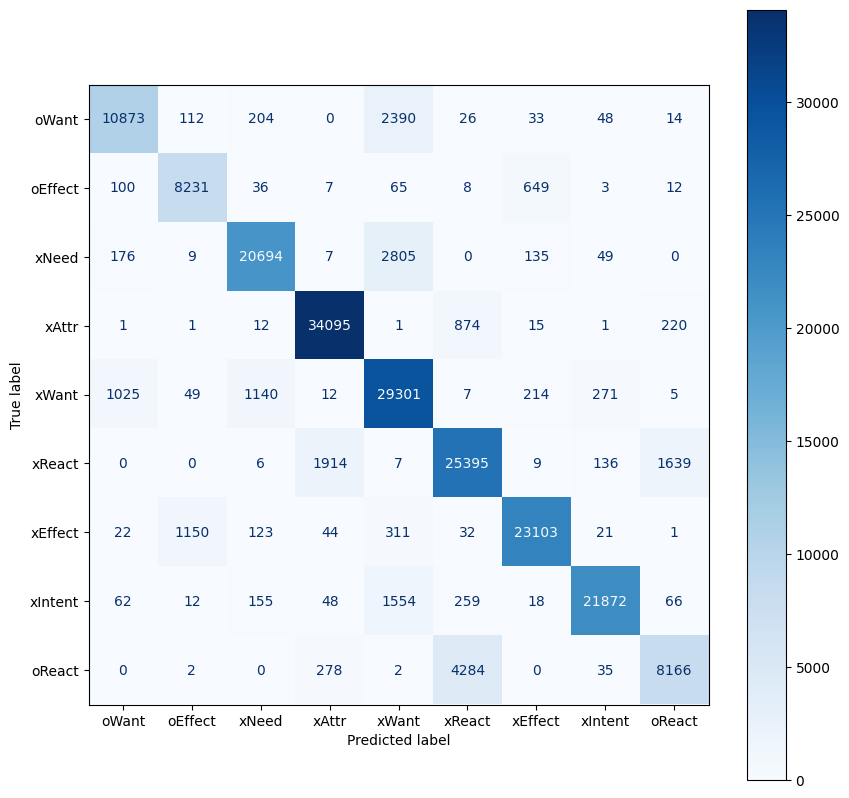

In [ ]:
# Step 3: Plot confusion matrix
# %matplotlib inline
# plt.figure(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(relation_vocab.keys()))
disp.plot(cmap=plt.cm.Blues)

# Show the confusion matrix
fig = disp.figure_
fig.set_size_inches(10, 10)  # 调整图表的大小
plt.show()

In [ ]:
# 获取类别数
num_classes = cm.shape[0]

# 初始化 Precision 和 Recall 列表
precision = []
recall = []

# 计算每个类别的 Precision 和 Recall
for i in range(num_classes):
    TP = cm[i, i]  # 对角线元素
    FP = np.sum(cm[:, i]) - TP  # 列上的所有元素之和减去 TP
    FN = np.sum(cm[i, :]) - TP  # 行上的所有元素之和减去 TP

    precision_i = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall_i = TP / (TP + FN) if (TP + FN) > 0 else 0

    precision.append(precision_i)
    recall.append(recall_i)

# 转换为百分比并打印结果
precision_percent = [f"{p * 100:.2f}%" for p in precision]
recall_percent = [f"{r * 100:.2f}%" for r in recall]

# 打印每个类别的 Precision 和 Recall
labels = ['xIntent', 'xEffect', 'xWant', 'xAttr', 'xNeed', 'xReact', 'oWant', 'oEffect', 'oReact']
for i, label in enumerate(labels):
    print(f"{label}: Precision = {precision_percent[i]}, Recall = {recall_percent[i]}")

xIntent: Precision = 88.69%, Recall = 79.36%
xEffect: Precision = 86.04%, Recall = 90.34%
xWant: Precision = 92.51%, Recall = 86.68%
xAttr: Precision = 93.65%, Recall = 96.81%
xNeed: Precision = 80.42%, Recall = 91.50%
xReact: Precision = 82.22%, Recall = 87.25%
oWant: Precision = 95.56%, Recall = 93.13%
oEffect: Precision = 97.49%, Recall = 90.96%
oReact: Precision = 80.67%, Recall = 63.96%


# Error Analysis

In [ ]:
# Assuming you have the validation dataset and trained model
val_predictions = model.predict(val_dataset)  # Get predictions for validation dataset
val_predictions_classes = np.argmax(val_predictions, axis=1)  # Get predicted class labels

# Get the true labels from the validation dataset
val_features = []
val_targets = []
for features, targets in val_dataset:
    val_features.extend(features.numpy())
    val_targets.extend(targets.numpy())

val_features = np.array(val_features)
val_targets = np.array(val_targets)

# Identify misclassified examples
misclassified_indices = np.where(val_predictions_classes != val_targets)[0]
misclassified_features = val_features[misclassified_indices]
misclassified_true_labels = val_targets[misclassified_indices]
misclassified_predicted_labels = val_predictions_classes[misclassified_indices]

# Create a DataFrame with the misclassified examples
error_analysis_df = pd.DataFrame({
    'features': list(misclassified_features),
    'true_label': misclassified_true_labels,
    'predicted_label': misclassified_predicted_labels
})

# If your features are sequences, you may also want to decode them back into readable strings
def decode_features(features, vocab):
    reverse_vocab = {idx: word for word, idx in vocab.items()}
    return ' '.join([reverse_vocab.get(idx, '<unk>') for idx in features if idx != 0])

# Example: Decode features for error analysis
error_analysis_df['decoded_features'] = error_analysis_df['features'].apply(lambda x: decode_features(x, vocab))

800/800 ━━━━━━━━━━━━━━━━━━━━ 63s 78ms/step


ModuleNotFoundError: No module named 'ace_tools'

In [ ]:
!pip install ace_tools
!pip show ace_tools

Name: ace_tools
Version: 0.0
Summary: A placeholder empty package
Home-page: 
Author: Paul McMillan
Author-email: paul@mcmillan.ws
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: 


In [ ]:
# Create a reverse mapping from indices to relation names
index_to_relation = {v: k for k, v in relation_vocab.items()}

# Apply the reverse mapping to 'true_label' and 'predicted_label' columns
error_analysis_df['true_label_name'] = error_analysis_df['true_label'].map(index_to_relation)
error_analysis_df['predicted_label_name'] = error_analysis_df['predicted_label'].map(index_to_relation)

In [ ]:
# Display the DataFrame for qualitative inspection
from IPython.display import display
display(error_analysis_df)

,features,true_label,predicted_label,decoded_features,error_category,true_label_name,predicted_label_name
0,"[1, 48, 334, 94, 4, 164, 12479, 6929, 22, 9576...",6,1,"PersonX is hit by a car ['dies', 'screams in p...",Missing Features or Ambiguous,xEffect,oEffect
1,"[1, 2012, 29, 1130, 7523, 0, 0, 0, 0, 0, 0, 0,...",8,5,PersonX publishes ___ online ['interested'],Missing Features or Ambiguous,oReact,xReact
2,"[1, 2, 29, 4, 3502, 6334, 1182, 4, 610, 9297, ...",7,4,PersonX gives ___ a massage ['to beryllium a g...,Missing Features or Ambiguous,xIntent,xWant
3,"[1, 34, 27, 28, 13741, 15300, 0, 0, 0, 0, 0, 0...",8,3,"PersonX takes PersonY's baby ['delighted', 'fr...",Missing Features or Ambiguous,oReact,xAttr
4,"[1, 266, 1993, 35, 451, 52723, 0, 0, 0, 0, 0, ...",8,5,"PersonX remains until PersonX's death ['sad,cr...",Missing Features or Ambiguous,oReact,xReact
...,...,...,...,...,...,...,...
22921,"[1, 197, 4, 198, 1025, 7226, 280, 6448, 21247,...",2,4,"PersonX buys a new truck ['save up money', 'sh...",Missing Features or Ambiguous,xNeed,xWant
22922,"[1, 168, 1590, 12, 1591, 7294, 28215, 0, 0, 0,...",3,5,"PersonX be allergic to peanuts ['scared', 'itc...",Missing Features or Ambiguous,xAttr,xReact
22923,"[1, 729, 12, 35, 313, 6334, 5946, 4, 7012, 632...",0,4,PersonX talks to PersonX's mother ['to build a...,Missing Features or Ambiguous,oWant,xWant
22924,"[1, 653, 137, 7007, 12415, 0, 0, 0, 0, 0, 0, 0...",3,5,"PersonX finally brand ['accomplished', 'comple...",Missing Features or Ambiguous,xAttr,xReact


In [ ]:
# Categorize errors based on observed patterns
def categorize_error(row):
    if row['true_label'] in ['Class_A', 'Class_B']:  # Use actual classes that might be ambiguous
        return 'Ambiguous Labeling'
    elif row['predicted_label'] in ['Class_X', 'Class_Y']:  # Use actual classes that could have noisy labels
        return 'Noisy Label'
    else:
        return 'Missing Features or Ambiguous'

# Apply the categorization to each row in the DataFrame
error_analysis_df['error_category'] = error_analysis_df.apply(categorize_error, axis=1)

# Display the first few rows of categorized errors for qualitative inspection
display(error_analysis_df[['true_label', 'predicted_label', 'error_category']].head(10))

# Count the number of errors in each category
error_category_counts = error_analysis_df['error_category'].value_counts()

,true_label,predicted_label,error_category
0,6,1,Missing Features or Ambiguous
1,8,5,Missing Features or Ambiguous
2,7,4,Missing Features or Ambiguous
3,8,3,Missing Features or Ambiguous
4,8,5,Missing Features or Ambiguous
5,7,0,Missing Features or Ambiguous
6,6,1,Missing Features or Ambiguous
7,3,8,Missing Features or Ambiguous
8,8,5,Missing Features or Ambiguous
9,2,4,Missing Features or Ambiguous


In [ ]:
error_analysis_df["error_category"].unique()

array(['Missing Features or Ambiguous'], dtype=object)

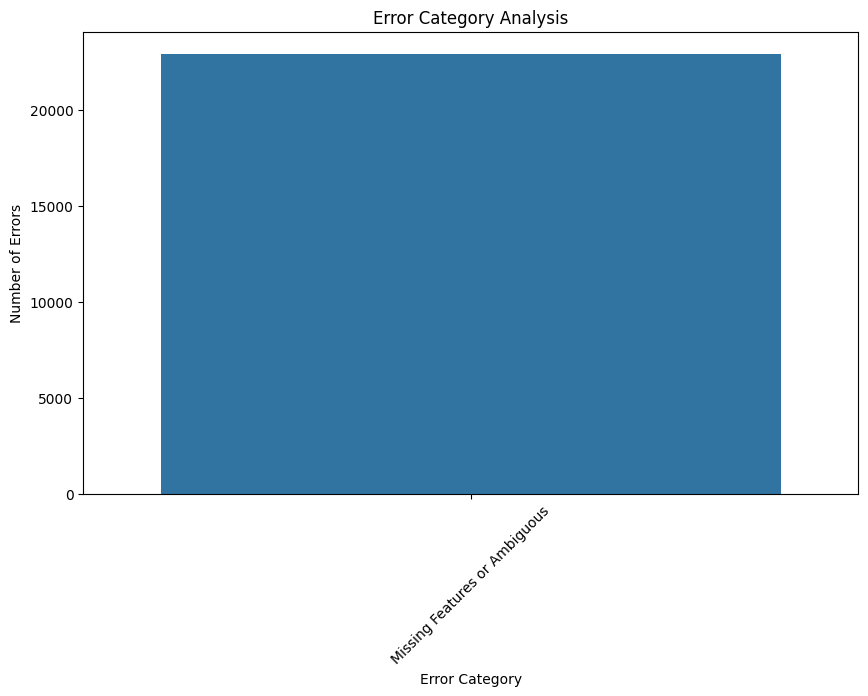

In [ ]:
# Plot the error categories
plt.figure(figsize=(10, 6))
sns.barplot(x=error_category_counts.index, y=error_category_counts.values)
plt.xlabel('Error Category')
plt.ylabel('Number of Errors')
plt.title('Error Category Analysis')
plt.xticks(rotation=45)
plt.show()